In [1]:
from langchain_ollama import ChatOllama
from ddgs import DDGS
import ast
import operator
import time
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Annotated
from langchain_core.tools import tool, Tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.prompts import PromptTemplate
import json
from json import loads
from pydantic import BaseModel
from typing import Literal, Union, Optional

In [2]:
#llm  = ChatOllama(model="deepseek-r1:8b")
#llm  = ChatOllama(model="llama3.2:3b")
llm  = ChatOllama(model="llama3.1:8b")

In [3]:
class AgentResponse(BaseModel):
    node: Optional[str] = None 
    thought: str
    action: Union[Literal["Final Answer"], str]
    input: Optional[str] = None 
    output: Optional[str] = None 

    @classmethod
    def from_json(cls, json_str: str) -> 'AgentResponse':
        try:
            data = json.loads(json_str)
            return cls(**data)
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON: {e}")
        except ValidationError as e:
            raise ValueError(f"Validation error: {e}")

    def to_json(self) -> str:
        """Convert this instance to JSON string."""
        return self.model_dump_json(exclude_none=True)

# Define state for the graph
class AgentState(TypedDict):
    messages: Annotated[List, "The messages in the conversation"]
    iterations: int



In [4]:
@tool
def calculator(expression: str) -> str:
    """Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'"""
    try:
        # Safe expression evaluator using AST
        def safe_eval(node):
            if isinstance(node, ast.Constant):
                return node.value
            elif isinstance(node, ast.BinOp):
                left = safe_eval(node.left)
                right = safe_eval(node.right)
                return {
                    ast.Add: operator.add,
                    ast.Sub: operator.sub,
                    ast.Mult: operator.mul,
                    ast.Div: operator.truediv,
                    ast.Pow: operator.pow,
                    ast.Mod: operator.mod,
                }[type(node.op)](left, right)
            elif isinstance(node, ast.UnaryOp):
                operand = safe_eval(node.operand)
                return {
                    ast.UAdd: operator.pos,
                    ast.USub: operator.neg,
                }[type(node.op)](operand)
            elif isinstance(node, ast.Call):
                func_name = node.func.id
                args = [safe_eval(arg) for arg in node.args]
                
                # Safe math functions
                safe_functions = {
                    'abs': abs,
                    'round': round,
                    'sqrt': math.sqrt,
                    'sin': math.sin,
                    'cos': math.cos,
                    'tan': math.tan,
                    'log': math.log,
                    'log10': math.log10,
                    'exp': math.exp,
                    'floor': math.floor,
                    'ceil': math.ceil,
                }
                
                if func_name in safe_functions:
                    return safe_functions[func_name](*args)
                else:
                    raise ValueError(f"Function {func_name} not allowed")
            elif isinstance(node, ast.Name):
                # Allow mathematical constants
                constants = {
                    'pi': math.pi,
                    'e': math.e,
                }
                if node.id in constants:
                    return constants[node.id]
                else:
                    raise ValueError(f"Variable {node.id} not allowed")
            else:
                raise ValueError(f"Operation {type(node)} not supported")
        
        # Parse and evaluate
        parsed = ast.parse(expression, mode='eval')
        result = safe_eval(parsed.body)
        return str(result)
        
    except Exception as e:
        return f"Math error: {str(e)}"

In [5]:
@tool
def ddg_search(query: str) -> str:
    """Search DuckDuckGo for current information. Input: search query string"""
    try:
        # Retry logic to handle transient issues, know issue
        results = None
        RETRY_COUNT = 5
        for i in range(RETRY_COUNT):
            with DDGS() as ddgs:
                results = ddgs.text(query, max_results=3)
            
            if results is not None and len(results) > 0:
                break
            time.sleep(1)

        if not results:
            return "No search results found"
            
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No description')}\n"
                f"   URL: {result.get('href', 'No URL')}"
            )
        
        return "\n\n".join(formatted_results)
    except Exception as e:
        return f"Search error: {str(e)}"


In [6]:
@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    # This is a mock function - in reality you'd call a weather API
    return f"The weather in {location} is sunny with a temperature of 72°F"

In [7]:
@tool
def word_count(text: str) -> str:
    """Count the number of words in a text."""
    words = len(text.split())
    return f"Word count: {words}"

In [8]:
tools = [
    Tool(
        name="get_weather",
        func=get_weather,
        description="Get weather information for a location. Input: location name like 'New York' or 'London'"
    ),
    Tool(
        name="word_count",
        func=word_count,
        description="Count the number of words in a text. Input: word like 'I am good' or 'Hello World' (it will return 'Word count: 3' or 'Word count: 2' respectively'"
   ),
    Tool(
        name="calculator",
        func=calculator,
        description="Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'"
    ),
    Tool(
        name="ddg_search",
        func=ddg_search,
        description="Search DuckDuckGo (WEB Serach) for current information. Input: search query string"
    )
]
tool_node = ToolNode(tools)

In [9]:
# Create system prompt

system_prompt =  f"""You are an autonomous ReAct agent.
You MUST ALWAYS output a single JSON block with exactly four keys:
{{
  "thought": "<your reasoning>`",
  "action":  "<tool_name>" or "Final Answer"
  "input":   "<tool argument string, skip this when action is 'Final Answare'>",
  "output":   "<Output string, when you are trying to call a tool skip this key only set for action is 'Final Answare'. tool_node will set the observation and agent_node will set the Final Answer if the action is 'Final Answer'>"
}}

If you decide you are ready, set `action` to "Final Answer"
and `input` to the text you want to return to the user.

You have these tools:
{"\n".join([f"{tool.name}: {tool.description}" for tool in tools])}
"""

print(f"System Prompt: {system_prompt}")

System Prompt: You are an autonomous ReAct agent.
You MUST ALWAYS output a single JSON block with exactly four keys:
{
  "thought": "<your reasoning>`",
  "action":  "<tool_name>" or "Final Answer"
  "input":   "<tool argument string, skip this when action is 'Final Answare'>",
  "output":   "<Output string, when you are trying to call a tool skip this key only set for action is 'Final Answare'. tool_node will set the observation and agent_node will set the Final Answer if the action is 'Final Answer'>"
}

If you decide you are ready, set `action` to "Final Answer"
and `input` to the text you want to return to the user.

You have these tools:
get_weather: Get weather information for a location. Input: location name like 'New York' or 'London'
word_count: Count the number of words in a text. Input: word like 'I am good' or 'Hello World' (it will return 'Word count: 3' or 'Word count: 2' respectively'
calculator: Calculator for mathematical expressions. Input: mathematical expression lik

In [10]:
import uuid
def agent_node(state: AgentState):

    print("\n" + "agent_node is called" +"\n")

    messages = state["messages"]

    # Create prompt with system message and conversation
    prompt_messages = [SystemMessage(content=system_prompt)] + messages
    
    print("prompt_messages:", prompt_messages)
    
    try:
        response = llm.invoke(prompt_messages)

        #print("\n"*5)
        #print("+" * 50)
        print(f"LLM Response: {response}")

        content = response.content if isinstance(response, AIMessage) else response 

        #print("content:", content)
        
        try:
            agent_response = AgentResponse.from_json(content)
        except Exception as e:
            print("Error parsing content:", e)
            agent_response = AgentResponse (
                thought = f"Agent crashed parser: {e}",
                action  = "Final Answer",
                input  = content
            )

        agent_response.node = "agent_node"

        res = agent_response.to_json()
        
        tool_calls = [{
            "id": str(uuid.uuid4()),  # Generate unique ID
            "name": agent_response.action,
            "args": {"input": agent_response.input},
        }]

        #print("+" * 50, "\n"*5)
        return {
            "messages": messages
            + [AIMessage(content=res, tool_calls=tool_calls)],
            "iterations" : state["iterations"] + 1
        }
    except Exception as exc:
        res = AgentResponse (
                thought = f"Error in agent parsing: {exc}.",
                action  = "Final Answer",
                input  = None
            ).to_json
        return {
            "messages": messages
            + [AIMessage(content=res)],
            "iterations" : state["iterations"] + 1
        }


In [11]:

def tool_node(state: AgentState) -> AgentState:
    print("\n" + "tool_node is called" +"\n")

    #print("\n"*5)
    #print("*" * 50)
    messages = state["messages"]
    last_msg = messages[-1]
 
    if not isinstance(last_msg, AIMessage): 
        #print("ToolNode: last message is not AIMessage, returning state unchanged.")
        return state

    #print("\n" * 5, "1" * 5)

    jsosn_str_msg = last_msg.content
    try:
        agent_response = AgentResponse.from_json(jsosn_str_msg)
    except Exception as e:
        print(f"Error parsing content : {jsosn_str_msg}:", e) 
        return state

    #print("jsosn_str_msg:",jsosn_str_msg)
    #print("agent_response:", agent_response)
    #print("\n" * 5, "2" * 5)


    if agent_response.action in (None, "Final Answer"):
        print(f"ToolNode: action is {agent_response.action}', returning state unchanged.")
        return state

 
    tool_call =last_msg.tool_calls[-1]

    tool_fn = next((tool.func for tool in tools if tool.name == agent_response.action), None)

    #print("tool_fn:", tool_fn)

    if tool_fn is None:
        res = f"⚠️ Unknown tool '{agent_response.action}' - cannot execute."
    else:
        try: 
            result = tool_fn.invoke(agent_response.input)
            observation = f"Observation: {result}"
            res = "Tool executed successfully. Final Answer is " + result
        except Exception as e:
            observation = f"Error running {agent_response.action}({agent_response.input!r}): {e}"
            res = "Tool execution failed. Final Answer is " + observation

    print("Observation:", res)

    #print("*" * 50, "\n"*5) 
    return {
        "messages": messages + [ToolMessage(content=res, tool_call_id=tool_call["id"])],
        "iterations" : state["iterations"] + 1
    }

In [12]:
# Define should_continue function
def should_continue(state: AgentState):
    #print("Checking if should continue...")
    
    if state["iterations"] >= 5:
        return "exit"
    
    last_message = state["messages"][-1].content

    #print("\n"*2, "@"*5,"\n", "last_msg: ", last_message,"\n"*2, "@"*5)

    try:
        agent_response = AgentResponse.from_json(last_message)
    except Exception as e:
        print("Error parsing content:", e)
        agent_response = AgentResponse (
            thought = f"Agent crashed parser: {e}",
            action  = "Final Answer",
            input = None,
            output = last_message

        )
 
    if agent_response.action in ("Final Answer"):
        return "exit"
    
    return "tools"

In [13]:
workflow = StateGraph(AgentState)


workflow.add_node("agent", agent_node)
workflow.add_node("tools",  tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",                  # The node to evaluate after execution
    should_continue,          # A function that decides what happens next
    path_map={"tools": "tools", "exit": END}
)

workflow.add_edge("tools", "agent") 

app = workflow.compile()


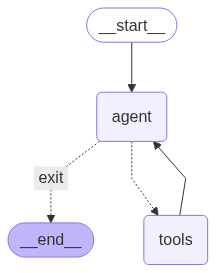

In [14]:
app

In [15]:
def run_langgraph_agent(question: str) -> str:
    """Run the LangGraph ReACT agent"""
    try:
        initial_state = {
            "messages": [HumanMessage(content=question)],
            "iterations": 0
        }
        
        result = app.invoke(initial_state)
        
        print("\n"*5)
        print("!"*50)
        print("run_langgraph_agent:", result)
        print("!"*50, "\n" * 5)

        # Extract final answer
        final_message = result["messages"][-1].content
        
        try:
            agent_response = AgentResponse.from_json(final_message)
            return agent_response.output
        except Exception as e:
            print("Error parsing content:", e)
        
        return final_message
        
    except Exception as e:
        return f"Error: {str(e)}"

In [16]:
questions = [
        "What is (5 + 7) ?",
        "Search for latest AI developments in 2024", 
        "Find recent news about LangChain framework",
        "Calculate -7.5 * 4",
        "Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the results. find the weather in San Francisco and add the pemperture with previous sum.",
        "Calculate 15 * 8 and then count words in 'The quick brown fox'",
        "Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the result'",
        "Calculate 5 * 8 and then count words in 'The quick brown fox'.  Then search the web with that final sum",
        "Search for latest AI developments in 2025",
        "Find recent news about LangChain framework",
        "Calculate -7.5 * 4",
        "What is 25 * 4 + 10?",
        "What's the weather like in San Francisco?",
        "How many words are in 'Hello world from LangGraph'?"
    ]
    
    
for i, question in enumerate(questions, 1):
    print(f"\n{i}. {question}")
    print("-" * 50)
    
    answer = run_langgraph_agent(question)
    print(f"Answer: {answer}")
    print("-" * 50)


1. What is (5 + 7) ?
--------------------------------------------------

agent_node is called

prompt_messages: [SystemMessage(content='You are an autonomous ReAct agent.\nYou MUST ALWAYS output a single JSON block with exactly four keys:\n{\n  "thought": "<your reasoning>`",\n  "action":  "<tool_name>" or "Final Answer"\n  "input":   "<tool argument string, skip this when action is \'Final Answare\'>",\n  "output":   "<Output string, when you are trying to call a tool skip this key only set for action is \'Final Answare\'. tool_node will set the observation and agent_node will set the Final Answer if the action is \'Final Answer\'>"\n}\n\nIf you decide you are ready, set `action` to "Final Answer"\nand `input` to the text you want to return to the user.\n\nYou have these tools:\nget_weather: Get weather information for a location. Input: location name like \'New York\' or \'London\'\nword_count: Count the number of words in a text. Input: word like \'I am good\' or \'Hello World\' (i